Aim
---
To investigate the map errors induced by altering the power law index of the GSMA.

In [23]:
import src.sky_models as SM
from anstey.generate import gen_err_gsma
import numpy as np
from scipy.special import erf
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import healpy as hp
import seaborn as sns

In [24]:
T230 = SM.foreground_gsma_nsidelo(nu=230)
TCMB = SM.T_CMB

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Want to see how relevant the CMB contribution to the following formula is:
$$
\frac{\Delta \mathbf{T}_{230}}{\mathbf{T}_{230}} = \left[\left(\frac{408}{230}\right)^{\boldsymbol{\delta}}-1\right]\left(1 - \frac{T_\mathrm{CMB}}{\mathbf{T}_{230}}\right)
$$

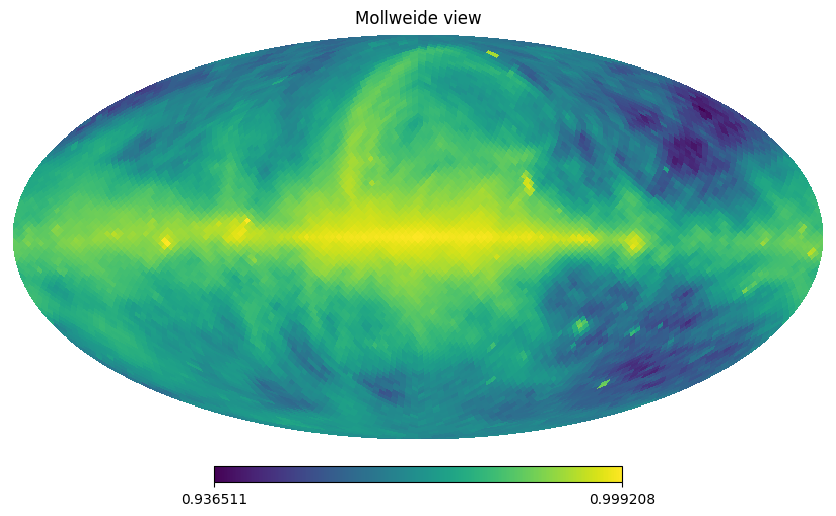

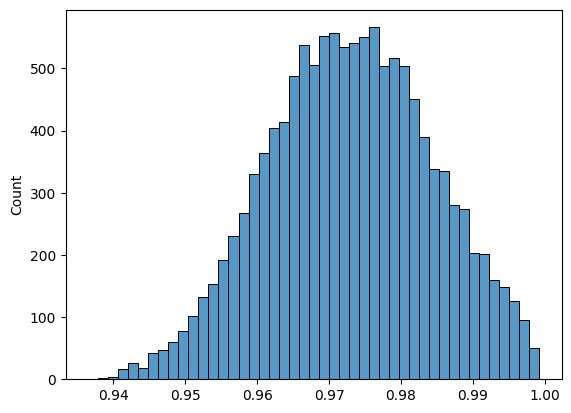

In [25]:
hp.mollview(1-TCMB/T230)
plt.show()
sns.histplot(1-TCMB/T230)
plt.show()

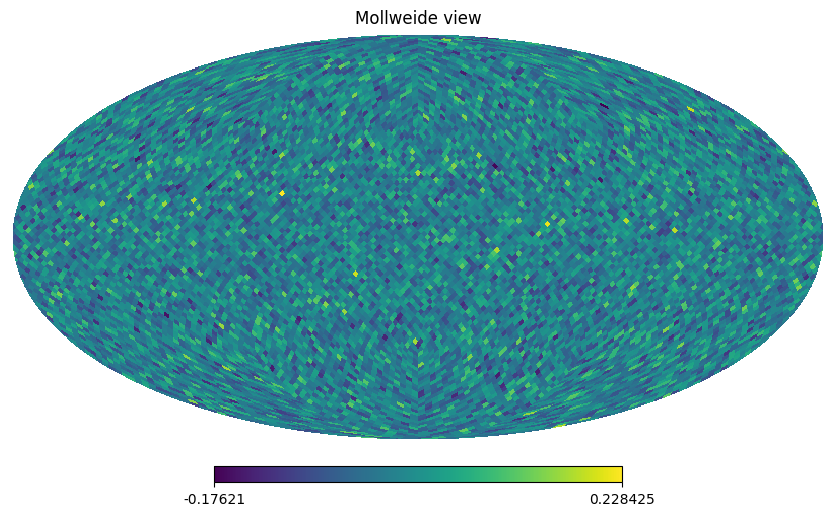

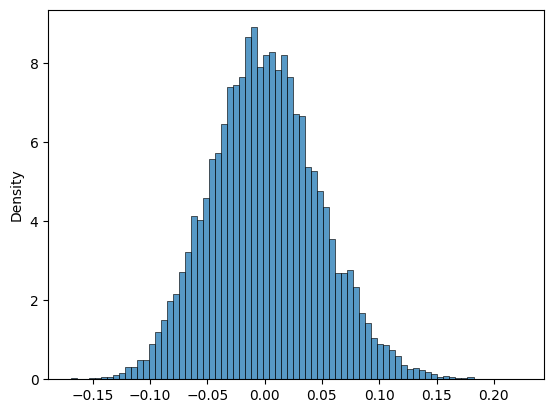

In [26]:
percent_err = 5
delta_vec = np.random.normal(scale=SM.basemap_err_to_delta(percent_err), size=np.shape(T230))
hp.mollview((408/230)**delta_vec - 1)
plt.show()
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=75, stat='density')
plt.show()

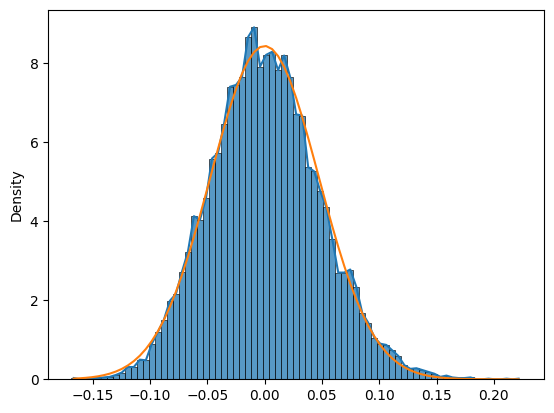

Gauss width = 0.047293673245050856
chi-sq = 4.619019705289116


In [27]:
p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
n, bins = np.histogram(p_vec, bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)

f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*(x)**2/sig**2)
res = curve_fit(f, xx, n)
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])
np.sqrt(res[1])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

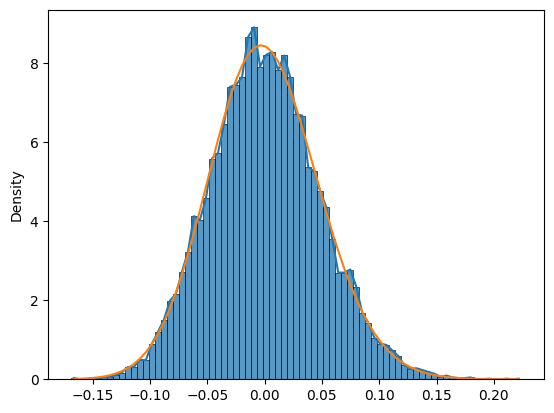

Gauss width = 0.05800613002230409
Gauss skew = 1.027860274123059
Gauss mean = -0.03279521513053061
Cov =  [[ 3.42537911e-06  2.24677522e-04 -4.61345206e-06]
 [ 2.24677522e-04  1.54764584e-02 -3.12365662e-04]
 [-4.61345206e-06 -3.12365662e-04  6.50297275e-06]]
chi-sq = 1.3581601678216473


In [28]:
p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
n, bins = np.histogram(p_vec, bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)

def skew_gauss(x, sig, sk, mu):
    gaussian = 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*(x-mu)**2/sig**2)
    return gaussian * (1 + erf(sk*(x-mu)/(np.sqrt(2)*sig)))

res = curve_fit(skew_gauss, xx, n)
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, skew_gauss(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])
print("Gauss skew =", res[0][1])
print("Gauss mean =", res[0][2])
print("Cov = ", res[1])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-skew_gauss(xx,*res[0]))**2/skew_gauss(xx,*res[0]))
print("chi-sq =", chi_sq)

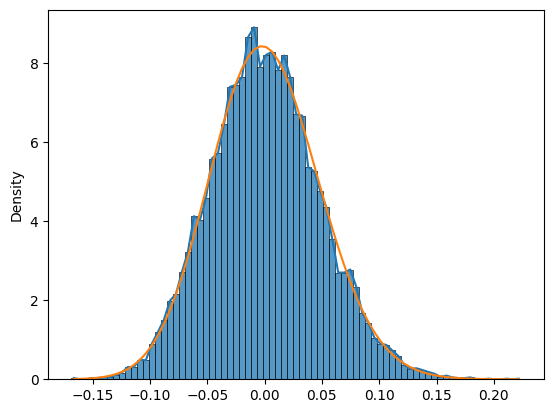

Gauss width = 0.04736733908820121
chi-sq = 1.419604152198712


In [29]:
p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
n, bins = np.histogram(p_vec, bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)

f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)*np.abs(1+x)) * np.exp(-0.5*np.log(x+1)**2/sig**2)
res = curve_fit(f, xx, n)
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])
np.sqrt(res[1])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

In [23]:
# Package the above into functions to find the skew as a function of delta.
def find_width_skewgauss(deltas):
    """
    Finds the width if the distribution is modelled as a skewed gaussian.
    """
    def skew_gauss(x, sig, sk, mu):
        gaussian = 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*(x-mu)**2/sig**2)
        return gaussian * (1 + erf(sk*(x-mu)/(np.sqrt(2)*sig)))
    widths=[]
    for delta in deltas:
        delta_vec = np.random.normal(scale=delta, size=np.shape(T230))
        p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
        
        n, bins = np.histogram(p_vec, bins=75, density=True)
        xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
        xx = np.array(xx)
        
        res = curve_fit(skew_gauss, xx, n)
        widths.append(res[0][0])
    return widths

def find_width_special(deltas):
    """
    Uses the special actual pdf to find the width.
    """
    f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)*np.abs(1+x)) * np.exp(-0.5*np.log(x+1)**2/sig**2)
    widths=[]
    for delta in deltas:
        delta_vec = np.random.normal(scale=delta, size=np.shape(T230))
        p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
        n, bins = np.histogram(p_vec, bins=75, density=True)
        xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
        xx = np.array(xx)
        
        res = curve_fit(f, xx, n)
        widths.append(res[0][0])
    return widths

In [24]:
SM.basemap_err_to_delta(20)

0.31808342041743537

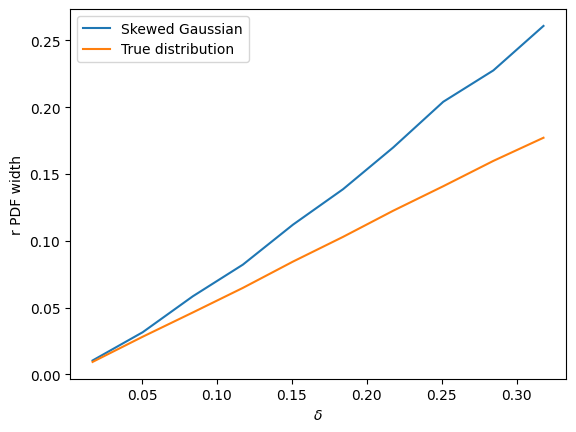

In [28]:
deltas = np.linspace(0.017,0.318, 10)
widths_skg = find_width_skewgauss(deltas)
widths_spc = find_width_special(deltas)
plt.plot(deltas, widths_skg, label='Skewed Gaussian')
plt.plot(deltas, widths_spc, label='True distribution')
plt.xlabel(r"$\delta$")
plt.ylabel(r"r PDF width")
plt.legend()

## Test new GSMA error generation


In [15]:
delta = 0.05

# Generate the fiducial GSMA map at 50, 230 and 408 MHz.
_, fid_maps = SM.foreground_gsma_alm_nsidelo(nu=[50, 230, 408], lmax=32, nside=32, original_map=True)
# Generate the GSMA map with basemap errors of 5% at the same frequencies
# on the T_230 basemap only.
_, bm1_maps = SM.foreground_gsma_alm_nsidelo(nu=[50, 230, 408], lmax=32, nside=32, original_map=True, delta=delta, err_type='bm1', seed=124)
# on both T_230 and T_408 basemaps.
_, bm2_maps = SM.foreground_gsma_alm_nsidelo(nu=[50, 230, 408], lmax=32, nside=32, original_map=True, delta=delta, err_type='bm2', seed=124)


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


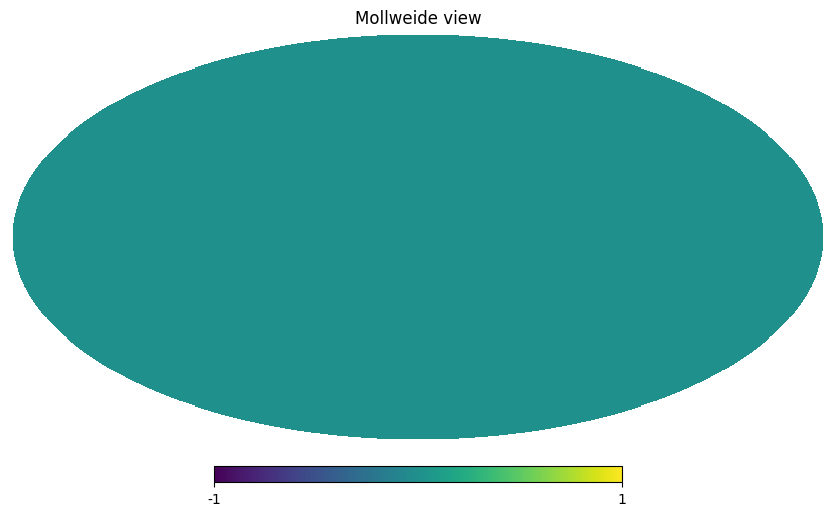

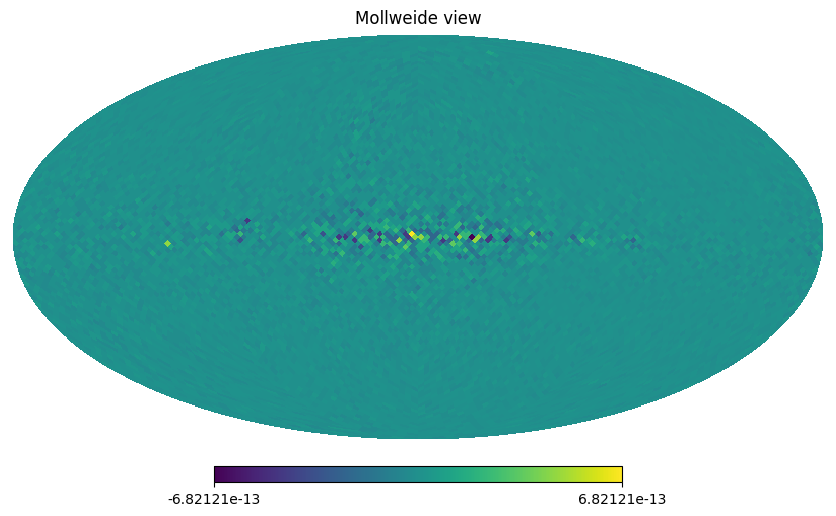

In [16]:
# Test the null cases: where we expect the maps to match.
# Fiducial T_408 vs the error case where only T_230 changes, evaluated at 408 MHz:
hp.mollview(fid_maps[2]-bm1_maps[2])
plt.show()
# The case where only T_230 changes vs the case where both change, evaluated at 230 MHz WITH THE SAME ERROR SEED:
hp.mollview(bm1_maps[1]-bm2_maps[1])
plt.show()

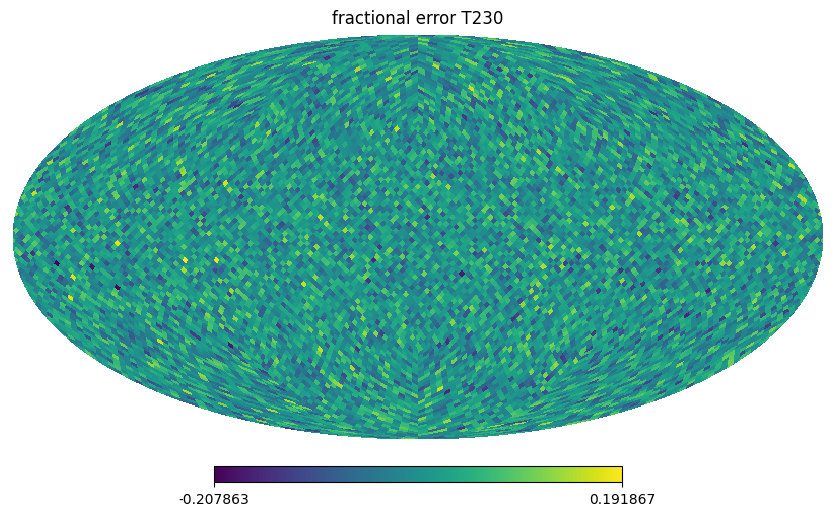

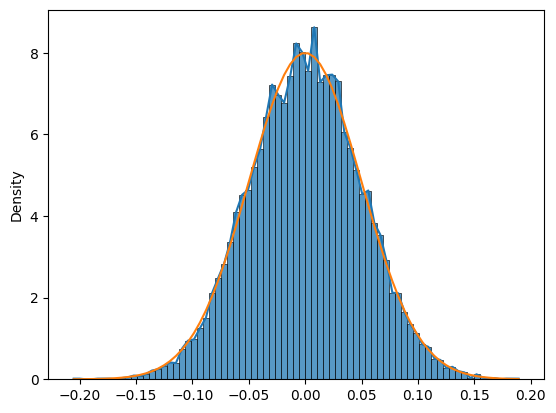

Gauss width = 0.049865924297637546
chi-sq = 1.0239233990807448


In [17]:
# Test the fractional error distributions.
# Fiducial T230 vs error T230 (both error cases produce the same T230 - see above)
hp.mollview((fid_maps[1]-bm1_maps[1])/fid_maps[1], title="fractional error T230")
plt.show()

# Fit the fractional errors with a gaussian to be sure.
n, bins = np.histogram((fid_maps[1]-bm1_maps[1])/fid_maps[1], bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)
f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*x**2/sig**2)
res = curve_fit(f, xx, n)

sns.histplot((fid_maps[1]-bm1_maps[1])/fid_maps[1], bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

plt.show()

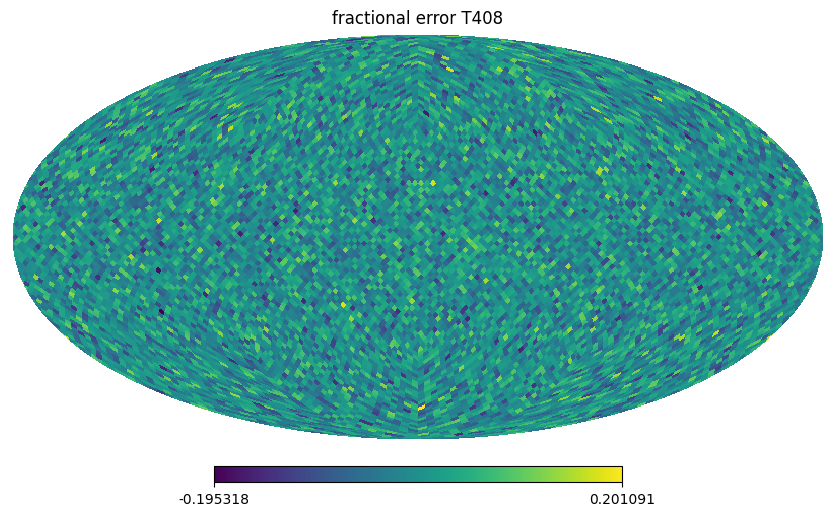

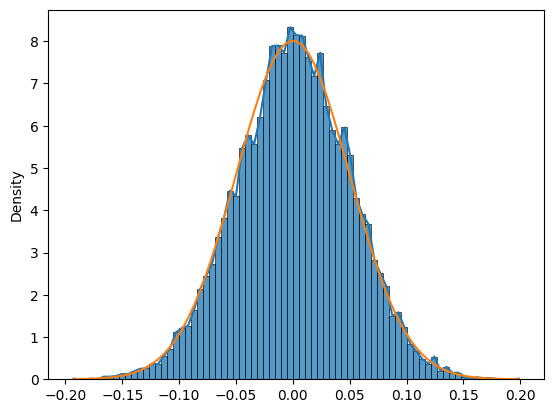

Gauss width = 0.04979367274912187
chi-sq = 1.2099343183290827


In [19]:
# Fiducial T408 vs error T408
hp.mollview((fid_maps[2]-bm2_maps[2])/fid_maps[2], title="fractional error T408")
plt.show()

# Fit the fractional errors with a gaussian to be sure.
n, bins = np.histogram((fid_maps[2]-bm2_maps[2])/fid_maps[2], bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)
f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*x**2/sig**2)
res = curve_fit(f, xx, n)

sns.histplot((fid_maps[2]-bm2_maps[2])/fid_maps[2], bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

plt.show()

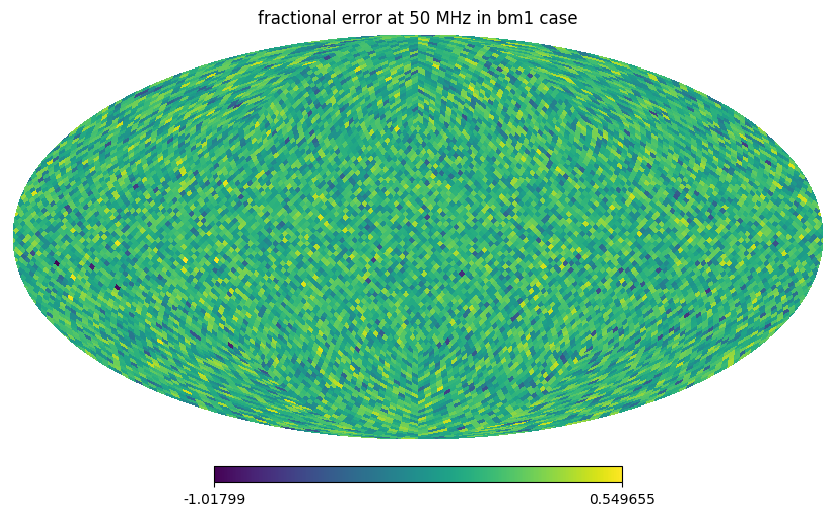

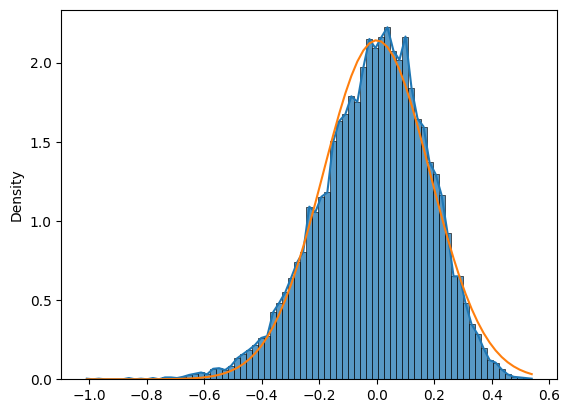

Gauss width = 0.18630433415497297
chi-sq = 23.876059733396474


In [21]:
# Finally, compare the fractional errors of the three maps at 50 MHz.
# First, fiducial vs error generated by varying T230 only:
hp.mollview((fid_maps[0]-bm1_maps[0])/fid_maps[0], title="fractional error at 50 MHz in bm1 case")
plt.show()

# Fit the fractional errors with a gaussian to be sure.
n, bins = np.histogram((fid_maps[0]-bm1_maps[0])/fid_maps[0], bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)
f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*x**2/sig**2)
res = curve_fit(f, xx, n)

sns.histplot((fid_maps[0]-bm1_maps[0])/fid_maps[0], bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

plt.show()

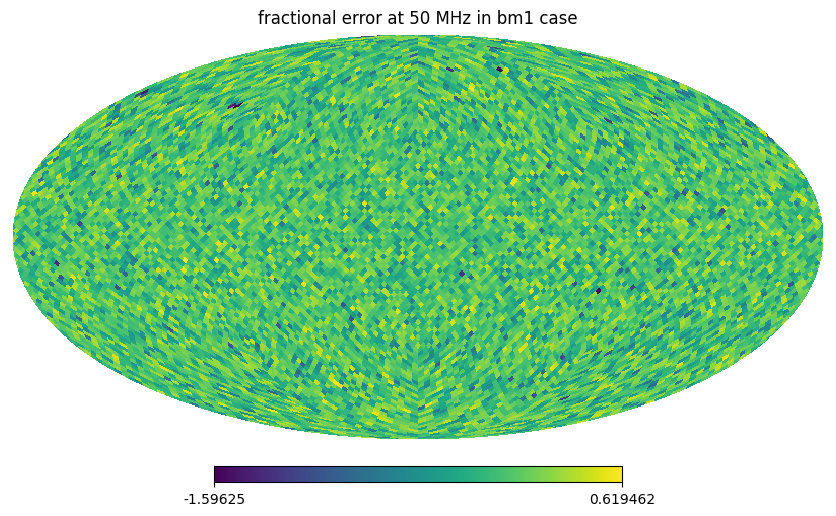

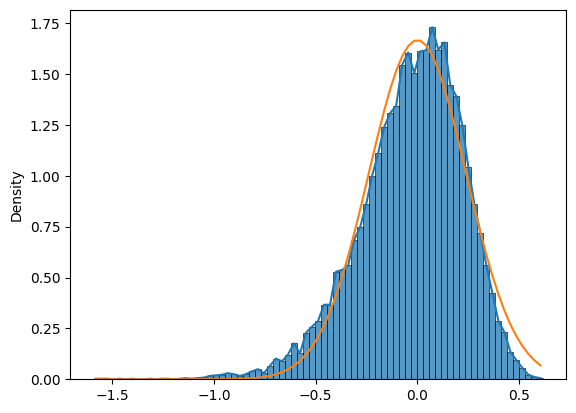

Gauss width = 0.23928540091851389
chi-sq = 23687.129520368027


In [22]:
# Finally, compare the fractional errors of the three maps at 50 MHz.
# First, fiducial vs error generated by varying T230 only:
hp.mollview((fid_maps[0]-bm2_maps[0])/fid_maps[0], title="fractional error at 50 MHz in bm2 case")
plt.show()

# Fit the fractional errors with a gaussian to be sure.
n, bins = np.histogram((fid_maps[0]-bm2_maps[0])/fid_maps[0], bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)
f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*x**2/sig**2)
res = curve_fit(f, xx, n)

sns.histplot((fid_maps[0]-bm2_maps[0])/fid_maps[0], bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

plt.show()

In [30]:
SM.basemap_err_to_delta(5)

0.08512072063579337

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


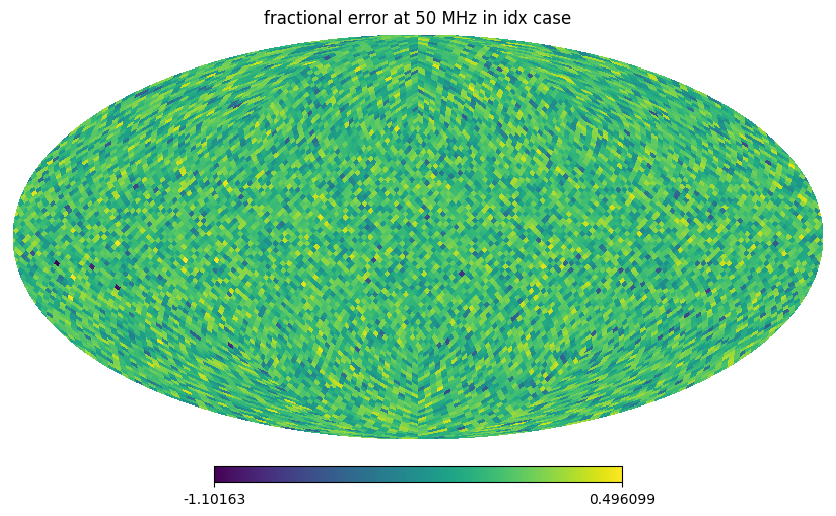

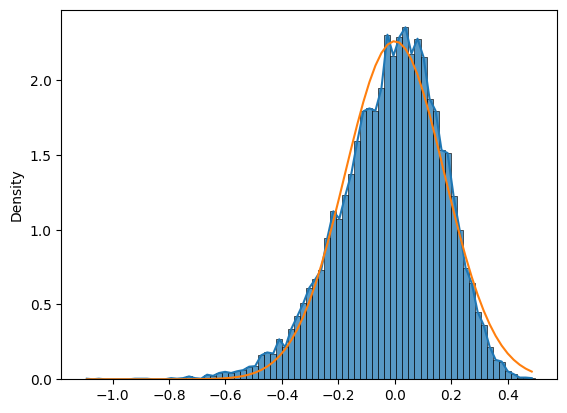

Gauss width = 0.17647581259586678
chi-sq = 1595.8000061234384


In [32]:
# Contrast this with the prior index generation case.
_, idx_maps = SM.foreground_gsma_alm_nsidelo(nu=[50, 230, 408], lmax=32, nside=32, original_map=True, delta=SM.basemap_err_to_delta(5), err_type='idx', seed=124)

hp.mollview((fid_maps[0]-idx_maps[0])/fid_maps[0], title="fractional error at 50 MHz in idx case")
plt.show()

# Fit the fractional errors with a gaussian to be sure.
n, bins = np.histogram((fid_maps[0]-idx_maps[0])/fid_maps[0], bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)
f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*x**2/sig**2)
res = curve_fit(f, xx, n)

sns.histplot((fid_maps[0]-idx_maps[0])/fid_maps[0], bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

plt.show()